<h1 style="color:rgb(0,120,170)">Neural Networks and Deep Learning</h1>
<h2 style="color:rgb(0,120,170)">Generative Adversarial Network</h2>

Vanilla implementation of a generative adversarial network as proposed by Goodfellow et al.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torchvision import datasets, transforms
from types import SimpleNamespace
from torchvision.utils import save_image
import matplotlib
import matplotlib.pyplot as plt
import os

In [ ]:
print(torch.__version__)

In [2]:
# Hyperparameters
args = SimpleNamespace(batch_size=64, 
                       test_batch_size=1000, 
                       epochs=10,
                       lr=0.0002, 
                       momentum=0.5, 
                       seed=1, 
                       log_interval=100)

torch.manual_seed(args.seed)
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

In [3]:
# Data loader (downloads data automatically the first time)
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(os.path.join('.','..','data'), 
                   train=True, download=True,
                   transform=transforms.Compose([transforms.ToTensor(),
                                                 transforms.Normalize([0.5], [0.5])
                                                ])),
    batch_size=args.batch_size, shuffle=True, **kwargs)

if not os.path.exists(os.path.join('.','samples')):
    os.makedirs(os.path.join('.','samples'))

Extracting ./../data/MNIST/raw/train-images-idx3-ubyte.gz to ./../data/MNIST/raw


Extracting ./../data/MNIST/raw/train-labels-idx1-ubyte.gz to ./../data/MNIST/raw


Extracting ./../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./../data/MNIST/raw




Extracting ./../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./../data/MNIST/raw
Processing...
Done!


/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


torch.Size([60000])
torch.Size([60000, 28, 28])
Input dimension is 784.




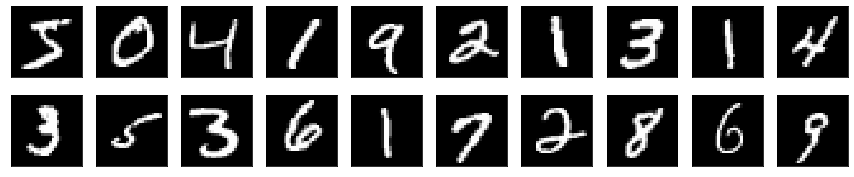

In [4]:
print(train_loader.dataset.targets.shape)
print(train_loader.dataset.data.shape)
input_dim = train_loader.dataset.data.shape[1]*train_loader.dataset.data.shape[2]
print("Input dimension is {}.".format(input_dim))
output_dim = 10

# Plot example images
fig=plt.figure(figsize=(15,3))
for image in range(20):
    show_img = train_loader.dataset.data[image].numpy().reshape(28, 28)
    fig.add_subplot(2,10,image+1)
    plt.xticks([]),plt.yticks([])
    plt.imshow(show_img, cmap='gray')
plt.show()

In [5]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.linear1 = nn.Linear(g_input_dim, 256)
        self.linear2 = nn.Linear(256, 512)
        self.linear3 = nn.Linear(512, 1024)
        self.linear4 = nn.Linear(1024, g_output_dim)
    
    def forward(self, x): 
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = F.relu(x)
        x = self.linear4(x)
        return torch.tanh(x)
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.linear1 = nn.Linear(d_input_dim, 1024)
        self.linear2 = nn.Linear(1024, 512)
        self.linear3 = nn.Linear(512, 256)
        self.linear4 = nn.Linear(256, 1)
    
    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = F.dropout(x, 0.3)
        x = self.linear2(x)
        x = F.relu(x)
        x = F.dropout(x, 0.3)
        x = self.linear3(x)
        x = F.relu(x)
        x = F.dropout(x, 0.3)
        x = self.linear4(x)
        return torch.sigmoid(x)

In [6]:
# Build network
z_latent = 100
mnist_dim = train_loader.dataset.data.size(1) * train_loader.dataset.data.size(2)

G = Generator(g_input_dim = z_latent, 
              g_output_dim = mnist_dim).to(device)

D = Discriminator(mnist_dim).to(device)

In [7]:
G

Generator(
  (linear1): Linear(in_features=100, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=512, bias=True)
  (linear3): Linear(in_features=512, out_features=1024, bias=True)
  (linear4): Linear(in_features=1024, out_features=784, bias=True)
)

In [8]:
D

Discriminator(
  (linear1): Linear(in_features=784, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=512, bias=True)
  (linear3): Linear(in_features=512, out_features=256, bias=True)
  (linear4): Linear(in_features=256, out_features=1, bias=True)
)

In [9]:
# loss
criterion = nn.BCELoss()
 
G_optimizer = optim.Adam(G.parameters(), lr = args.lr)
D_optimizer = optim.Adam(D.parameters(), lr = args.lr)

In [10]:
def train_discriminator(x):
    D.zero_grad()

    # discriminator loss on real
    x_real, y_real = x.view(-1, mnist_dim), torch.ones(x.view(-1, mnist_dim).shape[0], 1)
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # discriminator loss on fake
    z = Variable(torch.randn(args.batch_size, z_latent).to(device))
    x_fake, y_fake = G(z), Variable(torch.zeros(args.batch_size, 1).to(device))

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # gradient backprop
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item()

In [11]:
def train_generator():
    G.zero_grad()

    z = Variable(torch.randn(args.batch_size, z_latent).to(device))
    y = Variable(torch.ones(args.batch_size, 1).to(device))

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    # gradient backprop
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()

In [12]:
for epoch in range(1, args.epochs+1):           
    D_losses, G_losses = [], []
    for x, _ in train_loader:
        D_losses.append(train_discriminator(x))
        G_losses.append(train_generator())

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), args.epochs, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))
    
    with torch.no_grad():
        test_z = Variable(torch.randn(args.batch_size, z_latent).to(device))
        generated = G(test_z)
        save_image(generated.view(generated.size(0), 1, 28, 28), os.path.join('.','samples','sample_{}.png'.format(epoch)))

print("Done")

[1/10]: loss_d: 0.321, loss_g: 3.959
[2/10]: loss_d: 0.205, loss_g: 4.938
[3/10]: loss_d: 0.323, loss_g: 3.268
[4/10]: loss_d: 0.390, loss_g: 2.958
[5/10]: loss_d: 0.427, loss_g: 3.057
[6/10]: loss_d: 0.486, loss_g: 2.719
[7/10]: loss_d: 0.626, loss_g: 2.156
[8/10]: loss_d: 0.727, loss_g: 1.946
[9/10]: loss_d: 0.806, loss_g: 1.709
[10/10]: loss_d: 0.897, loss_g: 1.568
Done
